In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
df.head(15)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [3]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [4]:
df.shape

(404290, 6)

In [5]:
df.dropna(axis=0, inplace=True)

In [7]:
df.shape

(404287, 6)

In [8]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

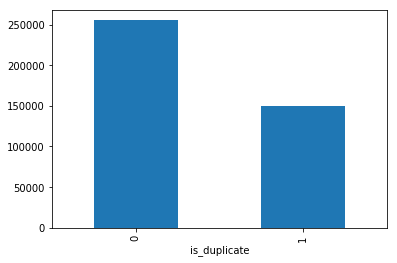

In [9]:
df.groupby("is_duplicate")["id"].count().plot.bar()

In [10]:
df.drop(['id','qid1','qid2'], axis=1, inplace=True)

In [11]:
df.shape

(404287, 3)

In [12]:
a=0
for i in range(a,a+15):
    print(df.question1[i])
    print(df.question2[i])
    print()

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?

Should I buy tiago?
What keeps childern active and far from phone and video games?

How can I be a good geologist?
What should I do to be a great geologist?

When do you use シ instea

In [13]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def clean(text, stem_words=True):
    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

    stops = set(stopwords.words("english"))
    # Membersihkan text dengan stemming word
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Membersihkan text / Stemming Word
    text = re.sub("\'s", " ", text) 
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # menghapus koma
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    
    # tambahkan padding ke tanda baca dan karakter khusus
    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
        
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # mereplace non asci menjadi asci
    
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    
    # membersihkan text rules yang didapat dari url : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # mereplace float number menjadi random number
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
  
    
    # menghapus padding dari text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # mengembalikan semua list kata yang telat di stemming
    return text